### Computation Graph

Following Andrej Karpathy's tutorial, we are building the abstract data type to build the computational graph that will enable backpropagation throughout a network.  
This exercise complements my first goal of build a neural network entirely in numpy that is scalable. Every feature that I would want in a network will be implemented in numpy.

In [24]:
import numpy as np
import math

In [25]:
class Value:

    def __init__(self, data, _children=(),_op='',label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        return Value(self.data+other.data,(self,other),'+')
    
    def __mul__(self,other):
        return Value(self.data*other.data,(self,other),'*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [26]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [27]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Example
We will run an example with our ADT to run do backprop thru a neuron

In [47]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

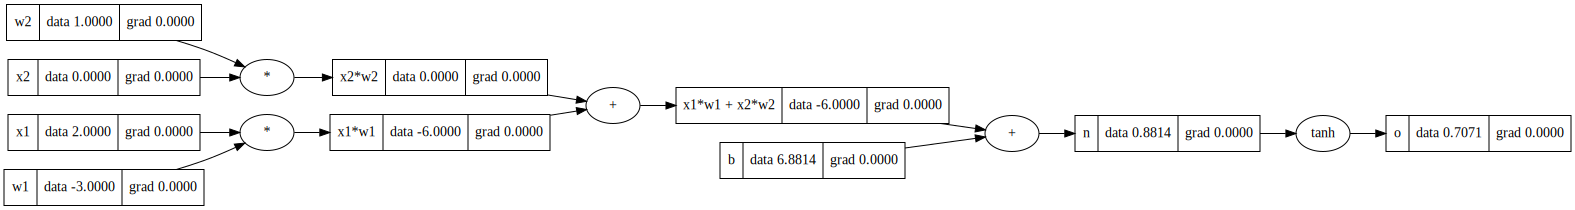

In [48]:
draw_dot(o)

### Let's attempt to backpropagate manually


\begin{align*}
o &= \tanh(n) \\
\frac{{do}}{{dn}} &= \frac{{d(\tanh(n))}}{{dn}} = 1 - \tanh**2(n) = 1 - o**2 \\
n &= x_1w_1 + x_2w_2 + b \\
\\
\frac{{d(n)}}{{d(x_1w_1 + x_2w_2)}} &= 1 && \frac{{d(n)}}{{db}} = 1 \\
\frac{{d(x_1w_1 + x_2w_2)}}{{d(x_2w_2)}} &= 1 && \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_1w_1)}} &= 1 \\
\frac{{d(x_2w_2)}}{{d(x_2)}} &= w_2 && \frac{{d(x_2w_2)}}{{d(w_2)}} &= x_2 \\
\frac{{d(x_1w_1)}}{{d(x_1)}} &= w_1 && \frac{{d(x_1w_1)}}{{d(w_1)}} &= x_1 \\
\\
\frac{{d(n)}}{{d(w_1)}} &= \frac{{d(n)}}{{d(x_1w_1 + x_2w_2)}} \cdot \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_1w_1)}} \cdot \frac{{d(x_1w_1)}}{{d(w_1)}} \\
 \frac{{dn}}{{d(x_2w_2)}} &= \frac{{dn}}{{d(x_1w_1 + x_2w_2)}} \cdot \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_2w_2)}} = 1 \cdot 1 \\
\\
\frac{{dn}}{{dw_2}} &= x_2 && \frac{{dn}}{{dw_1}} &= x_1 \\
\frac{{dn}}{{dx_2}} &= w_2 && \frac{{dn}}{{dx_1}} &= w_1
\end{align*}


\[
\begin{align*}
\frac{{do}}{{dn}} &= 1 - o^2 \\
\frac{{do}}{{db}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{db}} = (1 - o^2) \cdot 1 \\
\frac{{do}}{{dx_1}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dx_1}} = (1 - o^2) \cdot w_1 \\
\frac{{do}}{{dx_2}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dx_2}} = (1 - o^2) \cdot w_2 \\
\frac{{do}}{{dw_1}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_1}} = (1 - o^2) \cdot x_1 \\
\frac{{do}}{{dw_2}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_2}} = (1 - o^2) \cdot x_2 \\
\end{align*}
\]


In [49]:
o.grad = 1.0
w1.grad = x1.data * (1-o.data**2)
x1.grad = w1.data * (1-o.data**2)
w2.grad = x2.data * (1-o.data**2)
x2.grad = w2.data * (1-o.data**2)
x1w1.grad = 1 * (1-o.data**2)
x2w2.grad = 1 * (1-o.data**2)
x1w1x2w2.grad = 1 * (1-o.data**2)
n.grad = (1-o.data**2)
b.grad = 1  * (1-o.data**2)

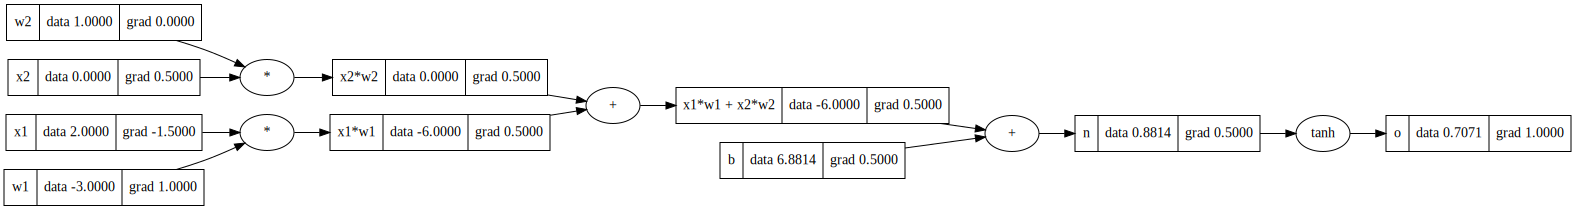

In [50]:
draw_dot(o)

### Backtracking the tree to verify our manual backprop


\begin{align*}
\text{Backpropagation of a Node } v_i : \sum_{j \in Ch(v_i)} \bar{v_j} \frac{\partial v_j}{\partial v_i}  \\
o &= \tanh(n) \\
o.\text{grad} &= 1 \\
n.\text{grad} &= (1 - o^2) = \text{n.grad} \\
b.\text{grad} &= \frac{{d(n \rightarrow o)}}{{db}} = \text{n.grad} \cdot \frac{{dn}}{{db}} = \text{n.grad} \\
(x_1w_1 + x_2w_2).\text{grad} &= \text{n.grad} \cdot 1 \\
(x_2w_2).\text{grad} &= (x_1w_1 + x_2w_2).\text{grad} \cdot 1 \\
(x_1w_1).\text{grad} &= (x_1w_1 + x_2w_2).\text{grad} \cdot 1 \\
w_1.\text{grad} &= \frac{{do}}{{dw_1}} = \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_1}} = \frac{{do}}{{dn}} \cdot \frac{{dn}}{{x_1w_1}} \cdot \frac{{dx_1w_1}}{{dw_1}} = \text{n.grad} \cdot x_1.\text{data} = (x_1w_1).\text{grad} \cdot x_1.\text{data} \\
x_1.\text{grad} &= o.\text{grad} \cdot \text{n.grad} \cdot (x_1w_1 + x_2w_2).\text{grad} \cdot (x_1w_1).\text{grad} = (x_1w_1).\text{grad} \cdot w_1.\text{data}
\end{align*}
\]